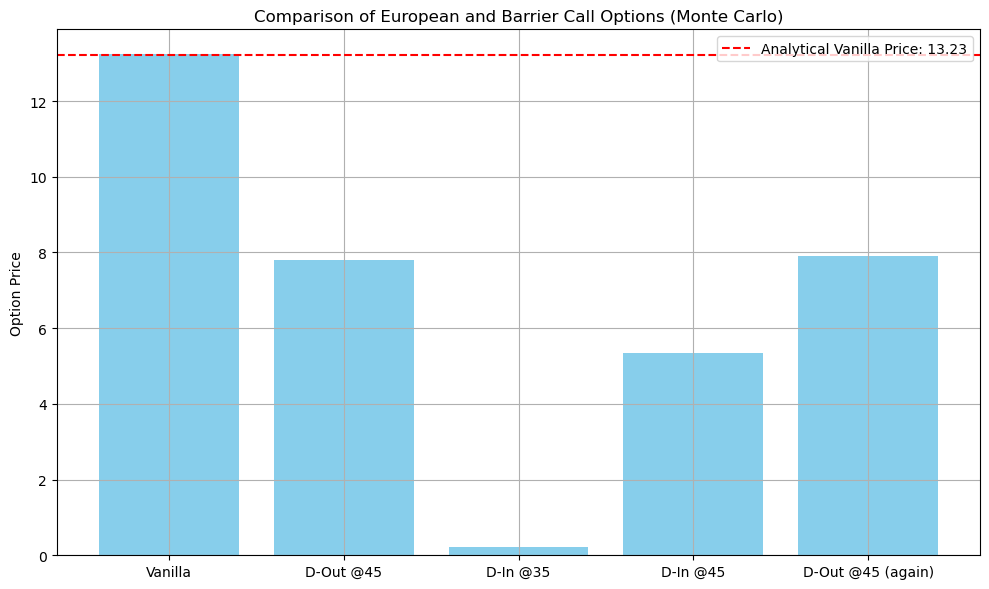

Analytical Vanilla Call Price: 13.2310
Vanilla MC:      13.2347
Down-and-Out @45: 7.7933
Down-and-In @35:  0.2265
Down-and-In @45:  5.3412
Down-and-Out @45 (again): 7.9066
Down-and-in + Down-and-out @45: 13.2478


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S = 50       # Spot price
K = 40       # Strike price
r = 0.05     # Risk-free rate
sigma = 0.3  # Volatility
T = 1        # Time to maturity
B_down_out = 45
B_down_in = 35
B_same = 45
n_simulations = 100000
n_steps = 252  # Daily steps in 1 year

# Black-Scholes price of a European Call
def bs_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Monte Carlo simulation for exotic options (corrected)
def monte_carlo_option_price(S, K, r, sigma, T, B, option_type="call", barrier_type=None, n=100000, n_steps=252):
    dt = T / n_steps
    Z = np.random.normal(0, 1, (n, n_steps))
    price_paths = np.zeros((n, n_steps + 1))
    price_paths[:, 0] = S

    for t in range(1, n_steps + 1):
        price_paths[:, t] = price_paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    ST = price_paths[:, -1]
    payoff = np.maximum(ST - K, 0) if option_type == "call" else np.maximum(K - ST, 0)

    if barrier_type == "down-and-out":
        barrier_hit = (price_paths <= B).any(axis=1)
        payoff[barrier_hit] = 0
    elif barrier_type == "down-and-in":
        barrier_hit = (price_paths <= B).any(axis=1)
        payoff[~barrier_hit] = 0

    return np.exp(-r * T) * np.mean(payoff)

# Analytical price of vanilla call
vanilla_price = bs_call(S, K, r, sigma, T)

# Monte Carlo simulations
np.random.seed(9465)
vanilla_mc = monte_carlo_option_price(S, K, r, sigma, T, B=None, barrier_type=None, n=n_simulations, n_steps=n_steps)
down_out_mc = monte_carlo_option_price(S, K, r, sigma, T, B_down_out, barrier_type="down-and-out", n=n_simulations, n_steps=n_steps)
down_in_mc = monte_carlo_option_price(S, K, r, sigma, T, B_down_in, barrier_type="down-and-in", n=n_simulations, n_steps=n_steps)
down_in_same_mc = monte_carlo_option_price(S, K, r, sigma, T, B_same, barrier_type="down-and-in", n=n_simulations, n_steps=n_steps)
down_out_same_mc = monte_carlo_option_price(S, K, r, sigma, T, B_same, barrier_type="down-and-out", n=n_simulations, n_steps=n_steps)

# Plotting
barrier_labels = ['Vanilla', 'D-Out @45', 'D-In @35', 'D-In @45', 'D-Out @45 (again)']
prices = [vanilla_mc, down_out_mc, down_in_mc, down_in_same_mc, down_out_same_mc]

plt.figure(figsize=(10, 6))
plt.bar(barrier_labels, prices, color='skyblue')
plt.axhline(vanilla_price, color='red', linestyle='--', label=f"Analytical Vanilla Price: {vanilla_price:.2f}")
plt.ylabel('Option Price')
plt.title('Comparison of European and Barrier Call Options (Monte Carlo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output results
print(f"Analytical Vanilla Call Price: {vanilla_price:.4f}")
print(f"Vanilla MC:      {vanilla_mc:.4f}")
print(f"Down-and-Out @45: {down_out_mc:.4f}")
print(f"Down-and-In @35:  {down_in_mc:.4f}")
print(f"Down-and-In @45:  {down_in_same_mc:.4f}")
print(f"Down-and-Out @45 (again): {down_out_same_mc:.4f}")
print(f"Down-and-in + Down-and-out @45: {down_in_same_mc + down_out_same_mc:.4f}")


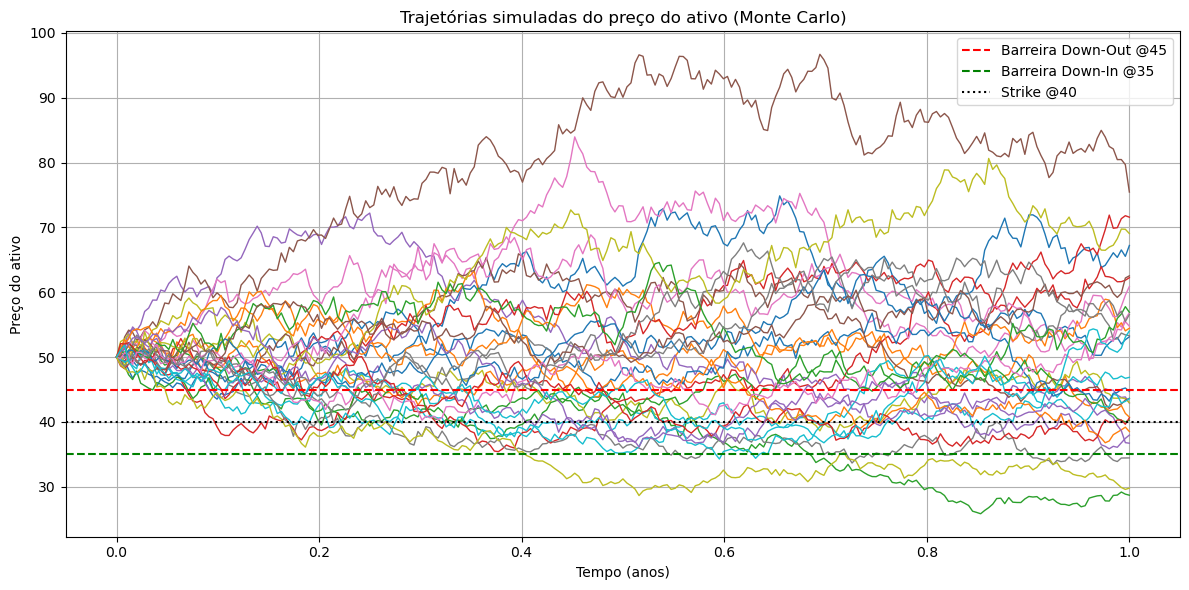

In [5]:
# Simulação de trajetórias do ativo para visualização das barreiras
def simulate_paths(S0, r, sigma, T, n_paths=100, steps=252):
    dt = T / steps
    paths = np.zeros((n_paths, steps + 1))
    paths[:, 0] = S0
    for t in range(1, steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Gerar as trajetórias
paths = simulate_paths(S, r, sigma, T, n_paths=30, steps=252)

# Plotar as trajetórias
plt.figure(figsize=(12, 6))
for i in range(paths.shape[0]):
    plt.plot(np.linspace(0, T, paths.shape[1]), paths[i], lw=1)

plt.axhline(B_down_out, color='red', linestyle='--', label='Barreira Down-Out @45')
plt.axhline(B_down_in, color='green', linestyle='--', label='Barreira Down-In @35')
plt.axhline(K, color='black', linestyle=':', label='Strike @40')
plt.title('Trajetórias simuladas do preço do ativo (Monte Carlo)')
plt.xlabel('Tempo (anos)')
plt.ylabel('Preço do ativo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
